In [6]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
import ccdproc as ccdp

import numpy as np
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

In [7]:
def get_data_and_headers(*args):
    all_data = list()
    all_headers = list()
    for path in args:
        files = ccdp.ImageFileCollection(path)
        night_data = [i for i in files.data()]
        night_headers = [i for i in files.headers()]
        all_data.extend(night_data)
        all_headers.extend(night_headers)
    return all_data, all_headers

In [8]:
filter = 'Red'
# Blue up to 86
# Red up to 86
# Green up to 86
# Luminance up to 174

night_1 = '../reduced-lights_2022_12_06/' + filter

data, headers = get_data_and_headers(night_1)
data, headers = data[:86], headers[:86]

In [9]:
len(data)

86

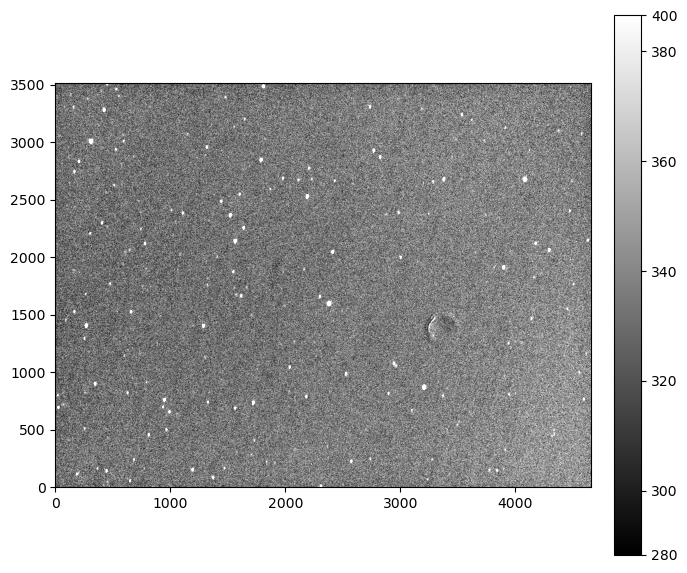

In [10]:
from convenience_functions import show_image

show_image(data[-1], cmap = 'gray')

In [11]:
import pandas as pd

def find_sources(array):
    mean, median, std = sigma_clipped_stats(array, sigma=2.5)
    daofind = DAOStarFinder(fwhm=9.0, threshold=5.*std)
    sources = daofind(array - median)
    return sources

def image_trimmer(sources, array):
    local_df = sources.to_pandas()
    image_size = array.shape
    x_trim = image_size[1] * 0.05
    y_trim = image_size[0] * 0.05
    local_df = local_df[(local_df['xcentroid'] - x_trim > 0) & (local_df['xcentroid'] + x_trim < image_size[1])]
    local_df = local_df[(local_df['ycentroid'] - y_trim > 0) & (local_df['ycentroid'] + y_trim < image_size[0])]
    return local_df.reset_index(drop = True).drop('id', axis = 'columns')

def excluding_duplicates(df, fwhm):
    #Taking initial comparison values from first row
    xcenter, ycenter, flux = df.iloc[0][['xcentroid', 'ycentroid', 'flux']]
    last_index = 0
    #Including first row in result
    filters = [True]

    #Skipping first row in comparisons
    for index, row in df.iloc[1:].iterrows():
        if (xcenter - 3*fwhm <= row['xcentroid'] <= 3*fwhm + xcenter) or (ycenter - 3*fwhm <= row[
            'ycentroid'] <= 3*fwhm + ycenter):
            # Once we have the two that are very close to each other we want to keep the one with the highest flux
            if df.iloc[last_index]['flux'] > row['flux']:
                filters.append(False)
            else:
                filters[last_index] = False
                filters.append(True)
                xcenter = row['xcentroid']
                ycenter = row['ycentroid']
                last_index = index
        else:
            filters.append(True)
            # Updating values to compare based on latest accepted row
            xcenter = row['xcentroid']
            ycenter = row['ycentroid']
            last_index = index
    result = df.loc[filters]
    return result.reset_index(drop=True)

def find_nearest(sources_1, sources_2):
    positions = np.transpose((sources_1['xcentroid'], sources_1['ycentroid']))
    positions_2 = np.transpose((sources_2['xcentroid'], sources_2['ycentroid']))
    mapping_dict = dict()
    for index, value in enumerate(positions):
        difference = np.subtract(positions_2, value)
        squared_difference = np.square(difference)
        min_index = np.sqrt(squared_difference.sum(axis = 1)).argmin()
        if index in mapping_dict:
            old_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][mapping_dict[index]])
            new_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][min_index])
            if old_difference_in_flux > new_difference_in_flux:
                mapping_dict[index] = min_index
        else:
            mapping_dict[index] = min_index
    for key, item in mapping_dict.items():
        x_1, y_1 = sources_1.iloc[key]['xcentroid'], sources_1.iloc[key]['ycentroid']
        x_2, y_2 = sources_2.iloc[item]['xcentroid'], sources_2.iloc[item]['ycentroid']
        distance = np.sqrt((x_1-x_2)**2+(y_1-y_2)**2)
        if distance > 100:
            mapping_dict[key] = np.nan
    return mapping_dict


In [12]:
excluding_duplicates(image_trimmer(find_sources(data[0]), data[0]), 9)

,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,2345.882167,179.759594,0.421750,0.039616,0.203815,121,0.0,2299.914191,20.462550,-3.277399
1,1408.809023,240.938661,0.547992,0.136799,0.222769,121,0.0,2285.037718,17.982670,-3.137135
2,1227.728931,304.792271,0.367486,0.103916,0.196234,121,0.0,2229.386919,21.238630,-3.317816
3,3810.207158,345.100213,0.300512,-0.121304,0.232238,121,0.0,864.244586,8.047597,-2.264166
4,2607.354114,402.211053,0.503522,0.072361,0.150435,121,0.0,2400.614661,19.187203,-3.207529
...,...,...,...,...,...,...,...,...,...,...
56,2752.342139,3106.546879,0.419030,-0.064452,-0.033337,121,0.0,2051.641684,15.482464,-2.974600
57,293.872318,3141.363998,0.377364,-0.058806,0.212722,121,0.0,11117.627902,78.448423,-4.736461
58,3088.699745,3173.970066,0.347034,0.031605,0.016729,121,0.0,140.197484,1.396519,-0.362617
59,3711.277601,3209.003910,0.744554,-0.179754,0.246632,121,0.0,427.951288,2.398849,-0.950007


In [13]:
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry
from astropy.stats import SigmaClip
import itertools

def signal_to_noise_ratio_v3(image_array, positions_df, r_start, r_end, step_size, delta_r, return_df = False):
    sigclip = SigmaClip(sigma=3, maxiters=5)
    # List of the aperture radius
    aperture_radius = list()

    # List of lists with the signal-to-noise ratios at each aperture
    all_snr_list = list()

    # Empty dataframe for putting everything in later
    snr_df = pd.DataFrame()

    # Get the positions that have a nan in them and ignore them
    nan_indexes = np.argwhere(pd.isnull(positions_df))
    if nan_indexes.size > 0: # Only works with a np.array
        no_nan_positions = list(positions_df[~pd.isnull(positions_df)])
    else: # Only works with a list
        no_nan_positions = list(positions_df)

    for r in np.arange(r_start, r_end + step_size, step_size):

        annulus_aperture = CircularAnnulus(no_nan_positions, r_in = r, r_out = r + delta_r)
        bkg_stats = ApertureStats(image_array, annulus_aperture, sigma_clip=sigclip)
        bkg_median = bkg_stats.median
        apertures = CircularAperture(no_nan_positions, r)
        phot_table = aperture_photometry(image_array, apertures)
        aper_stats = ApertureStats(image_array, apertures, sigma_clip=None)
        aperture_area = aper_stats.sum_aper_area.value
        total_bkg = bkg_median * aperture_area
        phot_bkgsub = phot_table['aperture_sum'] - total_bkg
        signal_to_noise_ratio = list(phot_bkgsub / total_bkg)
        aperture_radius.append(r)
        for nan_index in nan_indexes:
            signal_to_noise_ratio.insert(nan_index[0], np.nan)
        all_snr_list.append(signal_to_noise_ratio)

    # Transpose the snr list
    stars_snr = list(map(list, itertools.zip_longest(*all_snr_list, fillvalue=None)))

    # Add the aperture radii in the first column
    snr_df['Aperture radii'] = aperture_radius

    # Create a column with the snr of each star at different radii
    for star_index, snr_list in enumerate(stars_snr):
        snr_df[f'Star {star_index}'] = snr_list

    indexes_of_max_snr = list(snr_df.idxmax())[1:] # Exclude the first one since it's the aperture radii

    optimal_radii = [snr_df['Aperture radii'].iloc[int(i)] if not np.isnan(i) else np.nan for i in indexes_of_max_snr]
    optimal_radius = np.nanmean(optimal_radii)

    if return_df:
        return snr_df
    else:
        return optimal_radius

In [14]:
def aperture_calculation(image_array, positions_df, r, delta_r, exp_time, gain, return_table = False):
    sigclip = SigmaClip(sigma=3, maxiters=5)
    magnitudes_list = list()
    fluxes_list = list()
    for position in positions_df:
        if position is not np.nan:
            annulus_aperture = CircularAnnulus(position, r_in = r, r_out = r + delta_r)
            bkg_stats = ApertureStats(image_array, annulus_aperture, sigma_clip=sigclip)
            bkg_median = bkg_stats.median
            apertures = CircularAperture(position, r)
            phot_table = aperture_photometry(image_array, apertures)
            aper_stats = ApertureStats(image_array, apertures, sigma_clip=None)
            aperture_area = aper_stats.sum_aper_area.value
            total_bkg = bkg_median * aperture_area
            phot_bkgsub = phot_table['aperture_sum'] - total_bkg
            phot_table['aperture_sum_bkgsub'] = phot_bkgsub
            flux = (gain * phot_bkgsub) / exp_time
            mag = 25 - 2.5 * np.log10(flux)
            magnitudes_list.append(mag[0])
            fluxes_list.append(flux[0])
        else:
            magnitudes_list.append(np.nan)
            fluxes_list.append(np.nan)
    if return_table:
        return phot_table
    else:
        return magnitudes_list, fluxes_list

In [15]:
dictionary_list = list()
sources_first_array = find_sources(data[0])
trimmed_sources_first_array = image_trimmer(sources_first_array, data[0])
sources_first_array_no_duplicates = excluding_duplicates(trimmed_sources_first_array, 9)

for index in range(1, len(data)):
    print(index)
    sources_next_array = find_sources(data[index])
    trimmed_sources_next_array = image_trimmer(sources_next_array, data[index])
    sources_next_array_no_duplicates = excluding_duplicates(trimmed_sources_next_array, 9)
    mapping_dictionary = find_nearest(sources_first_array_no_duplicates, sources_next_array_no_duplicates)
    dictionary_list.append(mapping_dictionary)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


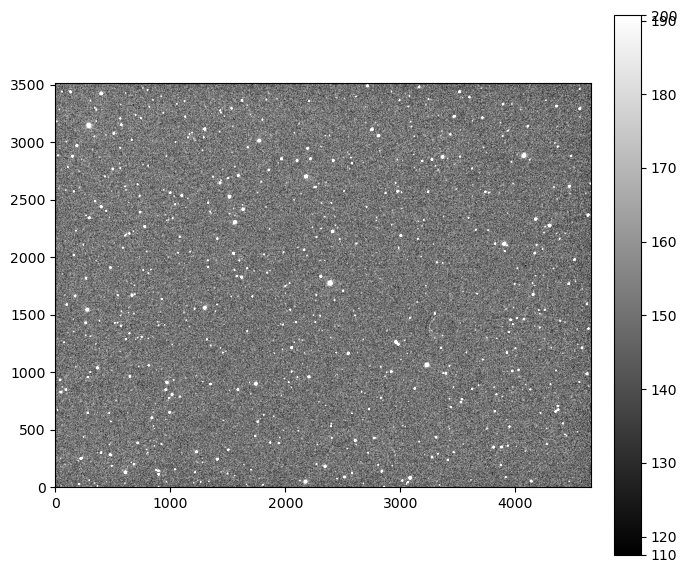

In [16]:
from convenience_functions import show_image

show_image(data[0], cmap = 'gray')

In [17]:
method_2_dict = dict()
method_2_dict[0] = list(dictionary_list[0].keys())
for index, dictionary in enumerate(dictionary_list):
    method_2_dict[index+1] = list(dictionary.values())

In [18]:
method_2_list_sources = list()

for key, item in method_2_dict.items():
    temp_list = list()
    found_sources = find_sources(data[key])
    trimmed_image = image_trimmer(found_sources, data[key])
    final_df = excluding_duplicates(trimmed_image, 9)
    for i in item:
        if i is np.nan:
            temp_list.append(np.nan)
        else:
            # temp_list.append(final_df.iloc[i]['flux'])
            temp_list.append((final_df.iloc[i]['xcentroid'], final_df.iloc[i]['ycentroid']))
    method_2_list_sources.append(temp_list)

In [19]:
all_positions_dict = dict()
for lst in method_2_list_sources:
    for index, item in enumerate(lst):
        if index not in all_positions_dict.keys():
            all_positions_dict[index] = list()
            all_positions_dict[index].append(item)
        else:
            all_positions_dict[index].append(item)

In [20]:
position_df = pd.DataFrame(all_positions_dict)

In [21]:
all_magnitudes = list()
all_fluxes = list()
for index in range(len(position_df)):
    print(index)
    positions = np.array(position_df.loc[index])
    loop_array = data[index]
    optimal_aperture_list = signal_to_noise_ratio_v3(loop_array, positions, 1, 30, 0.1, 10)
    magnitudes, fluxes = aperture_calculation(loop_array, positions, optimal_aperture_list, 10, 16, 1)
    all_fluxes.append(fluxes)
    all_magnitudes.append(magnitudes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


In [22]:
all_magnitudes_transposed = list(map(list, itertools.zip_longest(*all_magnitudes, fillvalue=None)))
all_fluxes_transposed = list(map(list, itertools.zip_longest(*all_fluxes, fillvalue=None)))

In [23]:
sources_first_array_no_duplicates

,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,2345.882167,179.759594,0.421750,0.039616,0.203815,121,0.0,2299.914191,20.462550,-3.277399
1,1408.809023,240.938661,0.547992,0.136799,0.222769,121,0.0,2285.037718,17.982670,-3.137135
2,1227.728931,304.792271,0.367486,0.103916,0.196234,121,0.0,2229.386919,21.238630,-3.317816
3,3810.207158,345.100213,0.300512,-0.121304,0.232238,121,0.0,864.244586,8.047597,-2.264166
4,2607.354114,402.211053,0.503522,0.072361,0.150435,121,0.0,2400.614661,19.187203,-3.207529
...,...,...,...,...,...,...,...,...,...,...
56,2752.342139,3106.546879,0.419030,-0.064452,-0.033337,121,0.0,2051.641684,15.482464,-2.974600
57,293.872318,3141.363998,0.377364,-0.058806,0.212722,121,0.0,11117.627902,78.448423,-4.736461
58,3088.699745,3173.970066,0.347034,0.031605,0.016729,121,0.0,140.197484,1.396519,-0.362617
59,3711.277601,3209.003910,0.744554,-0.179754,0.246632,121,0.0,427.951288,2.398849,-0.950007


In [24]:
RV_UMa_index = 25

RV_UMa_magnitudes = [all_magnitudes_transposed[RV_UMa_index]]
RV_UMa_fluxes = [all_fluxes_transposed[RV_UMa_index]]


saturated_stars_and_RV_UMa = [2, 31, 15, RV_UMa_index]

In [25]:
stars_index =[i for i in range(len(sources_first_array_no_duplicates)) if i not in saturated_stars_and_RV_UMa]
magnitude_list_standard_stars = [all_magnitudes_transposed[i] for i in stars_index]
flux_list_standard_stars = [all_fluxes_transposed[i] for i in stars_index]

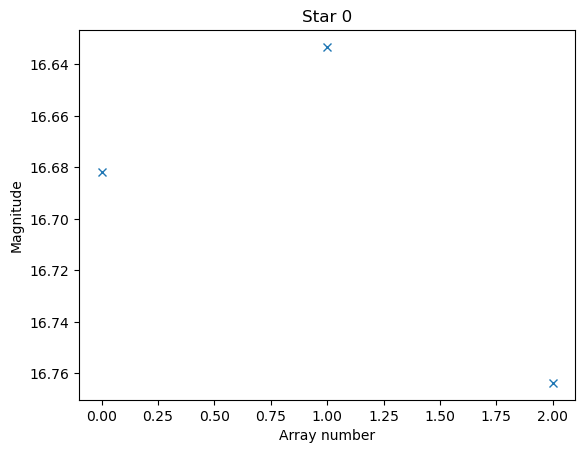

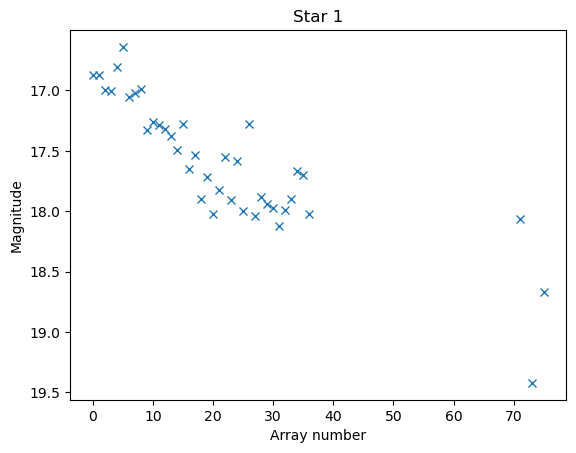

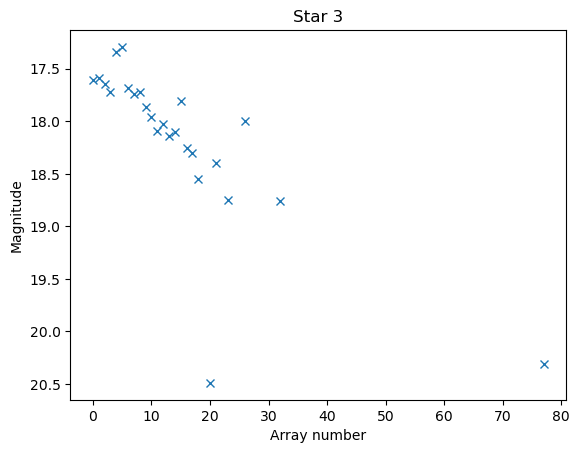

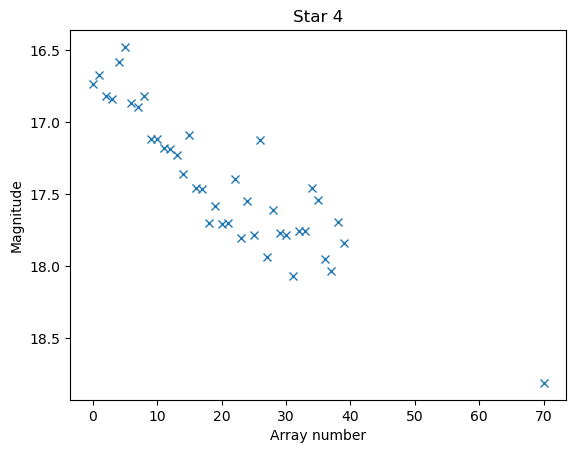

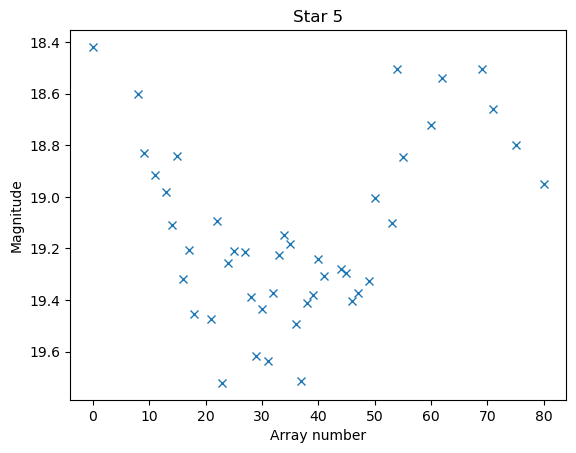

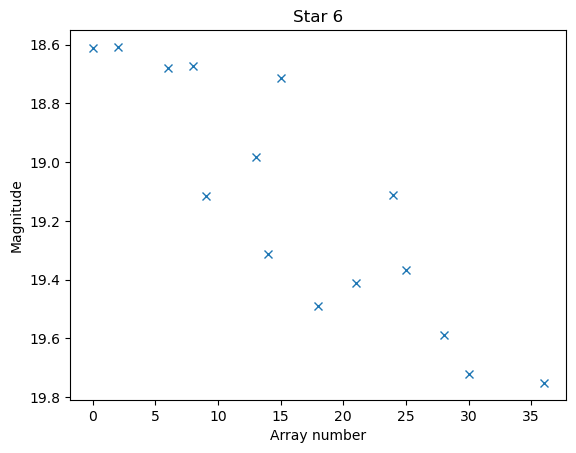

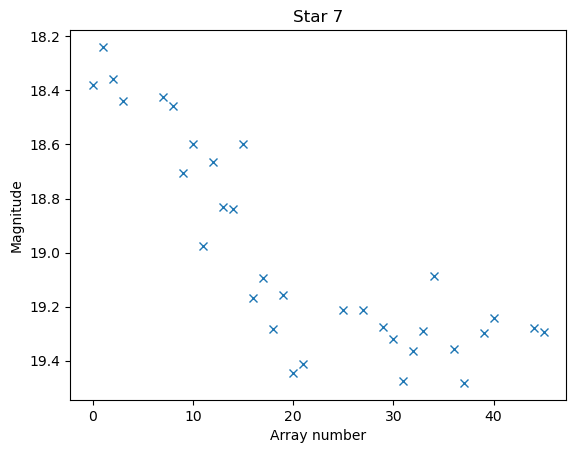

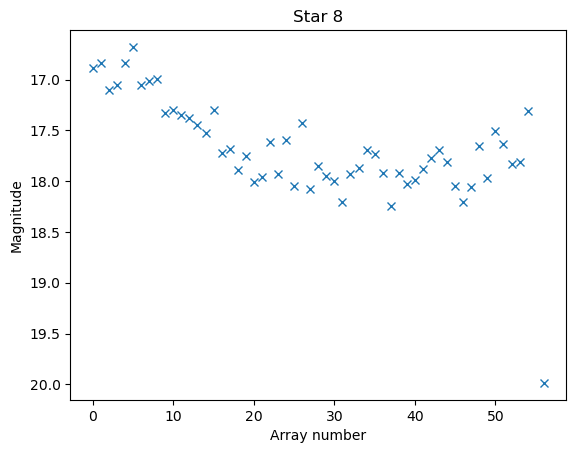

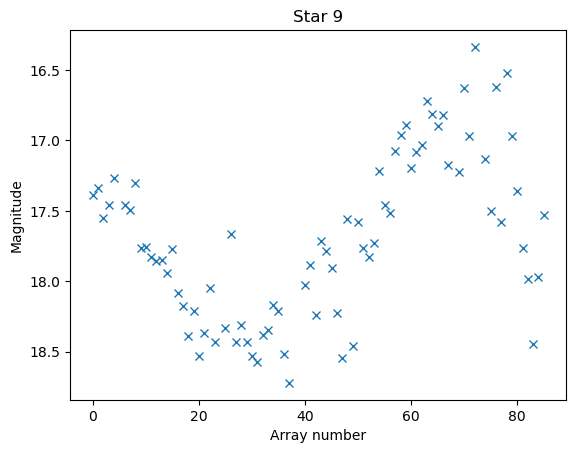

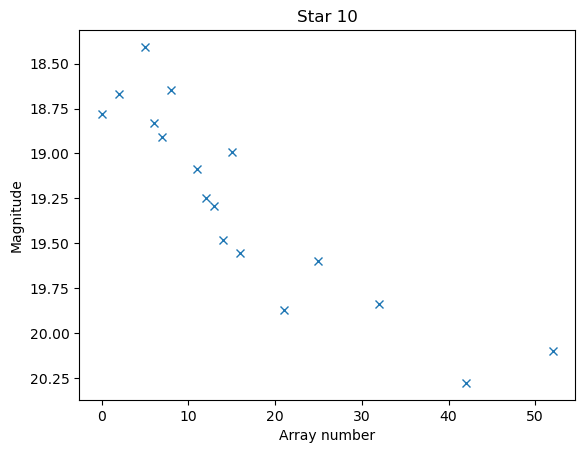

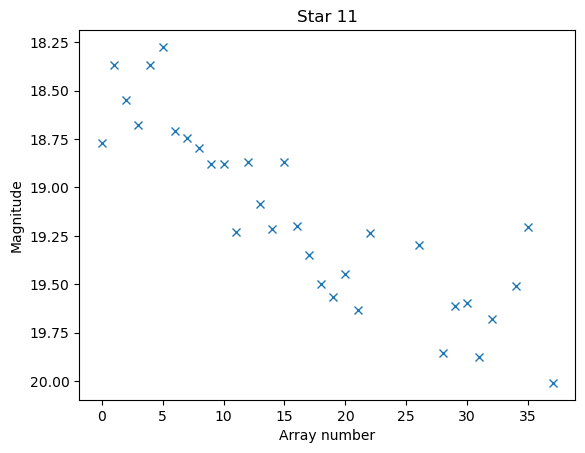

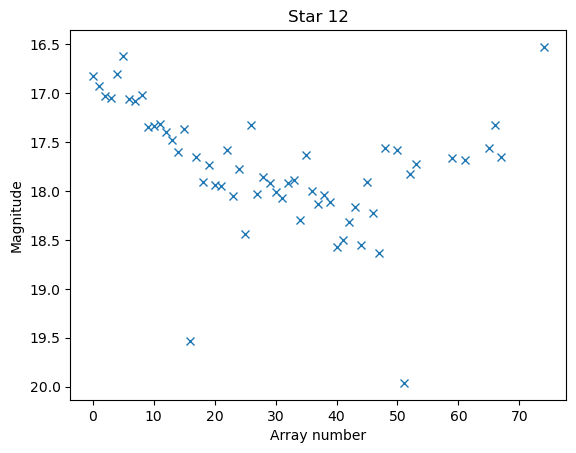

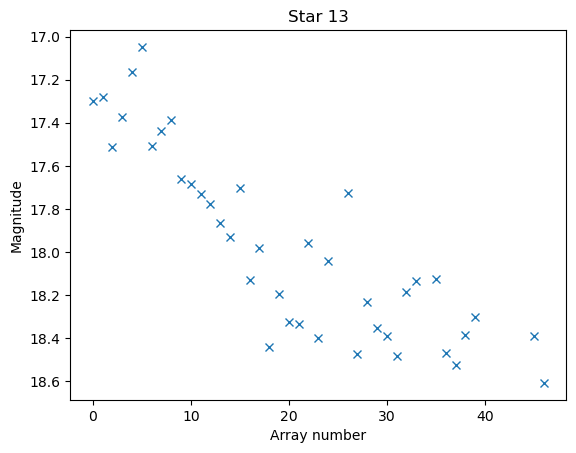

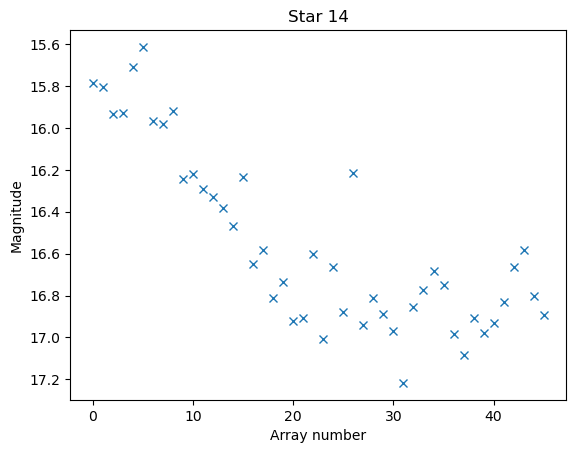

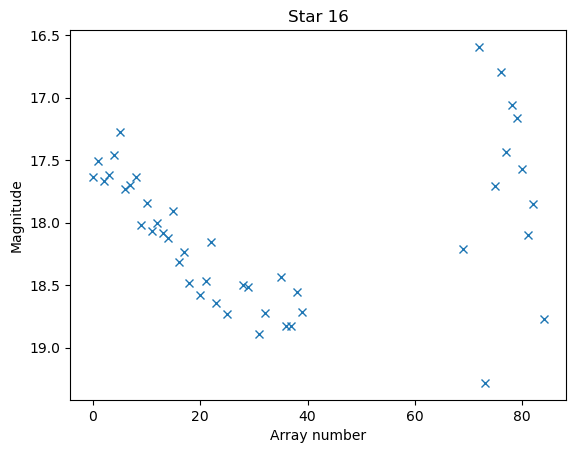

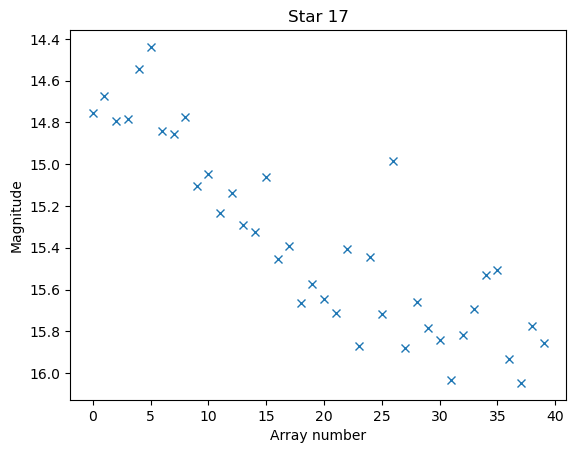

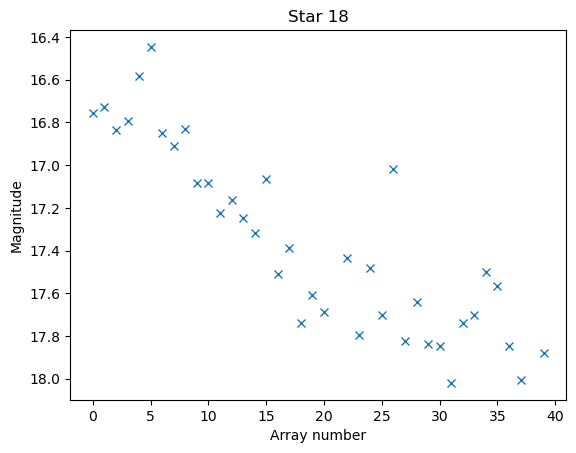

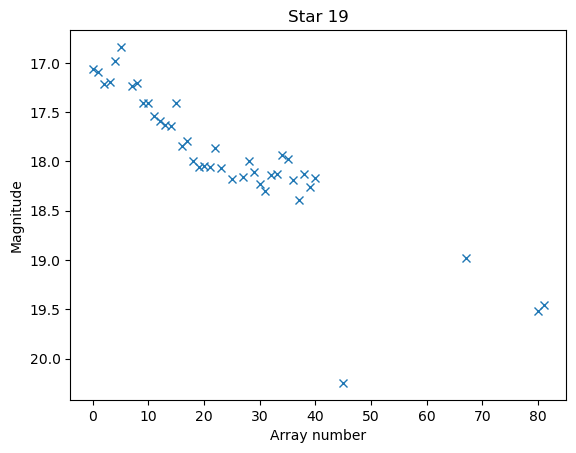

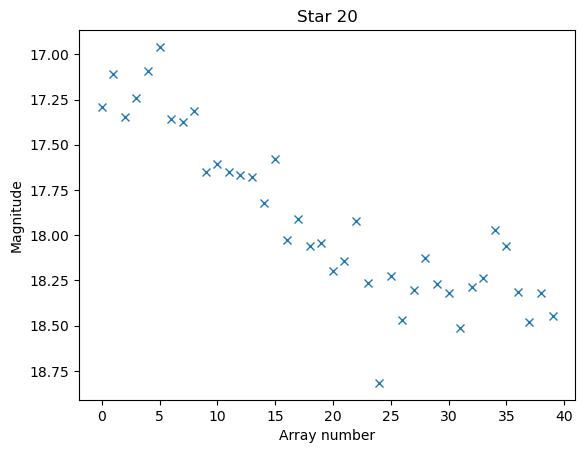

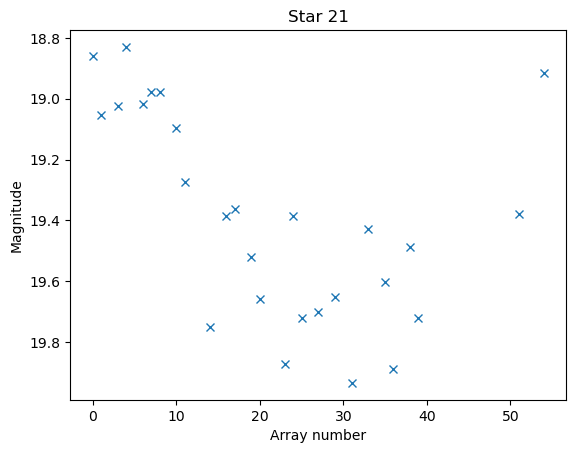

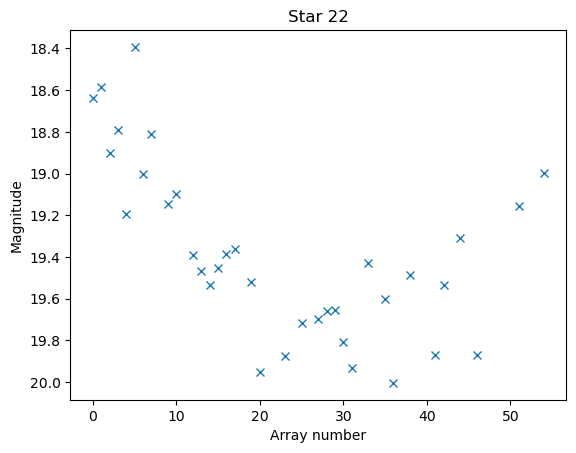

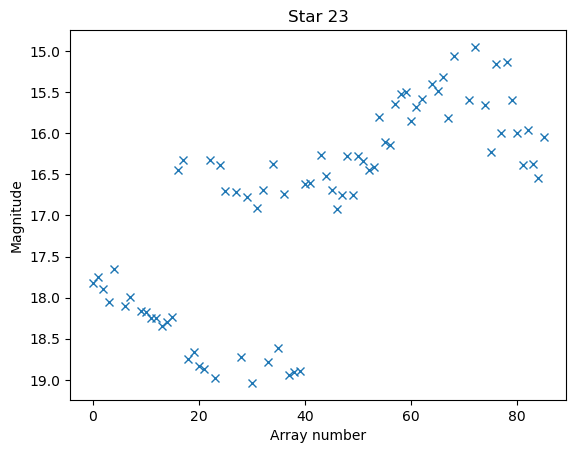

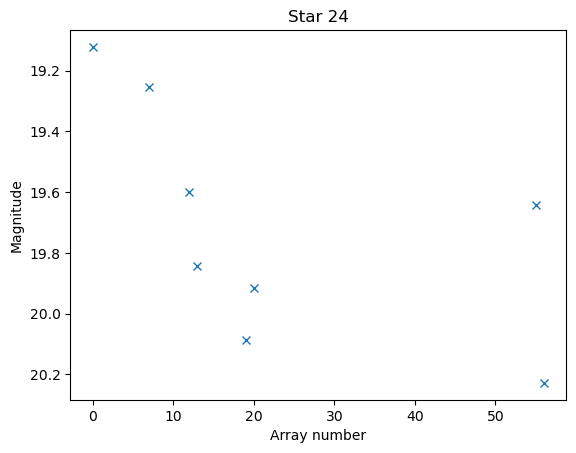

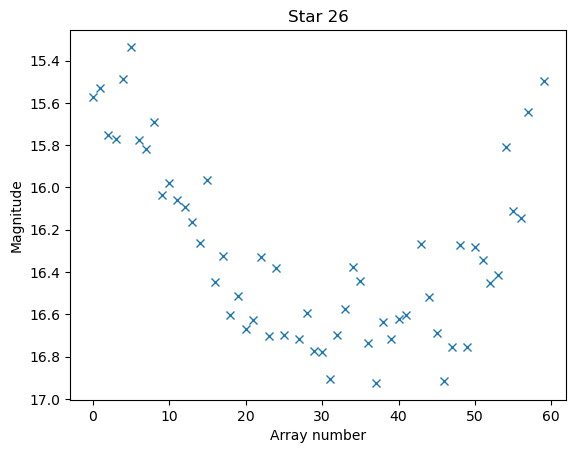

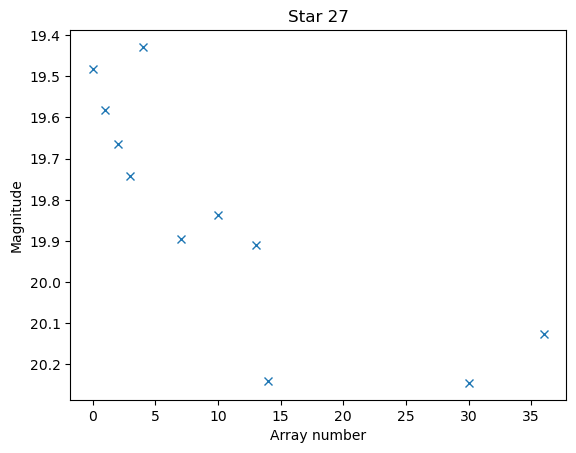

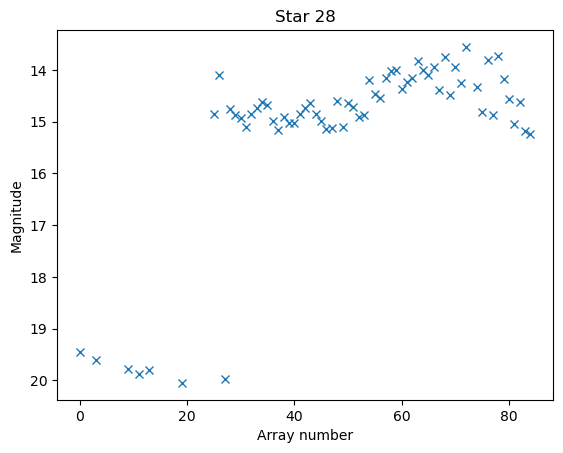

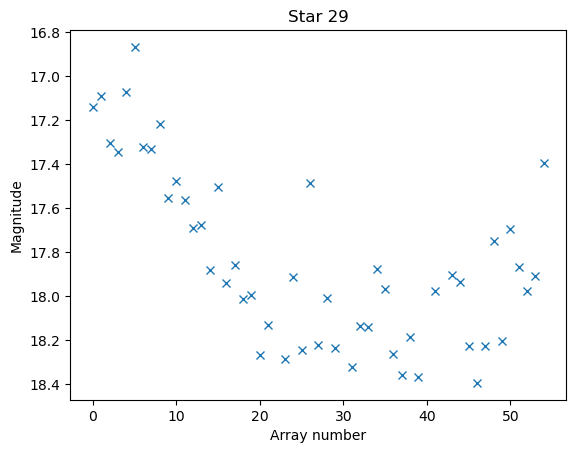

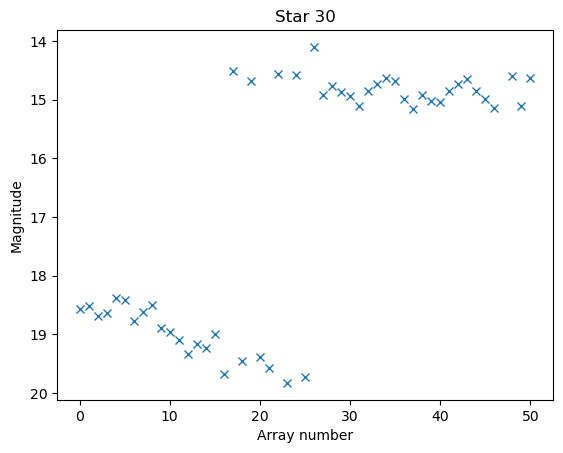

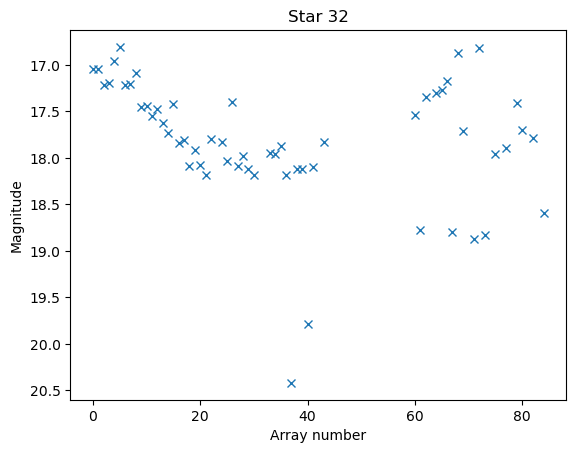

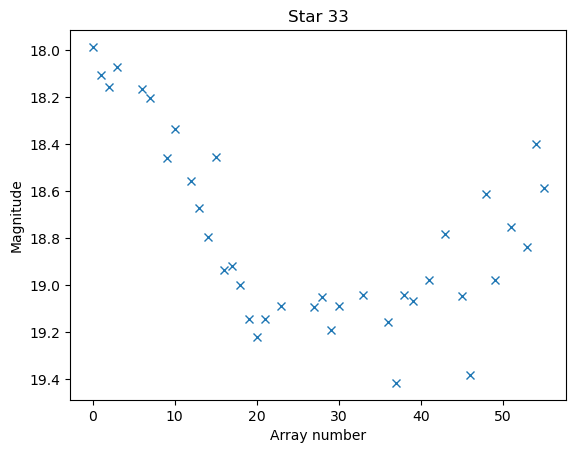

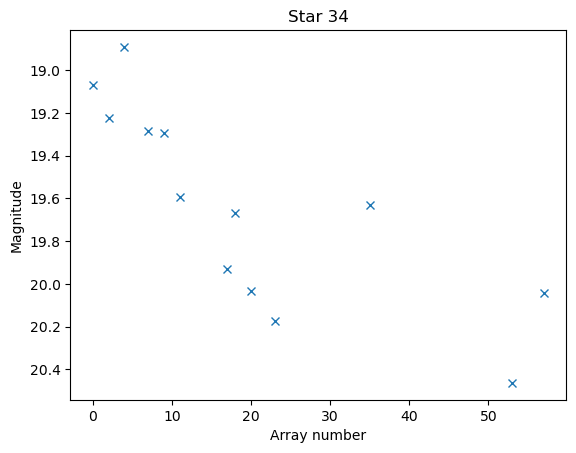

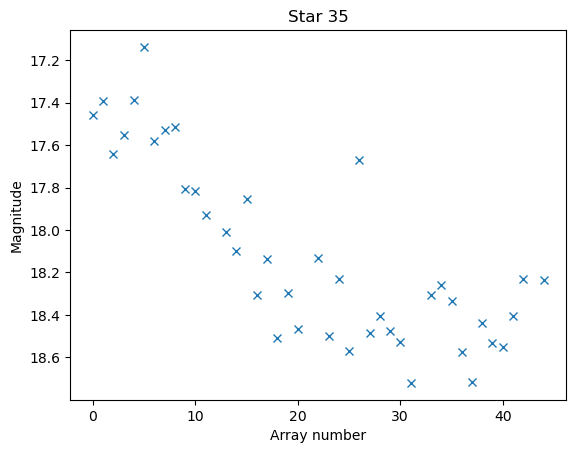

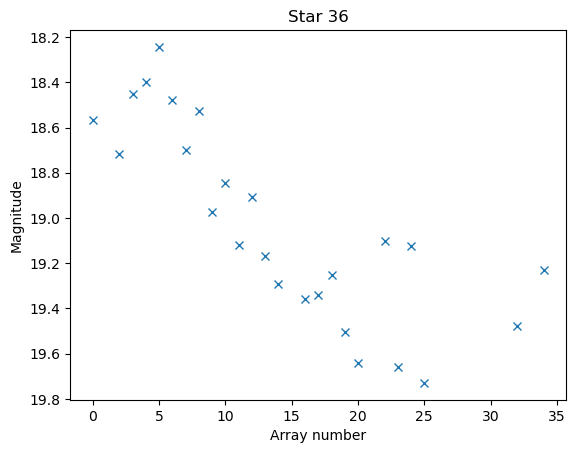

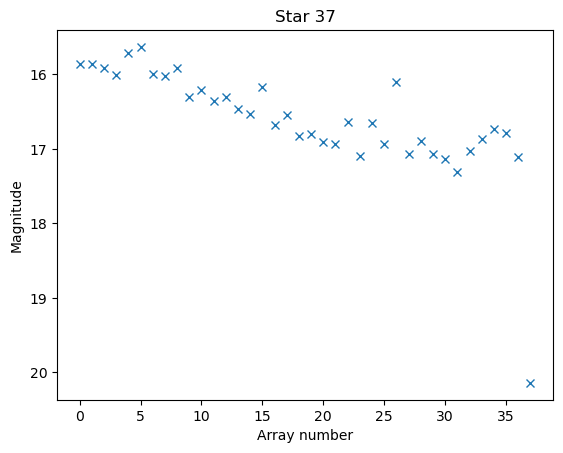

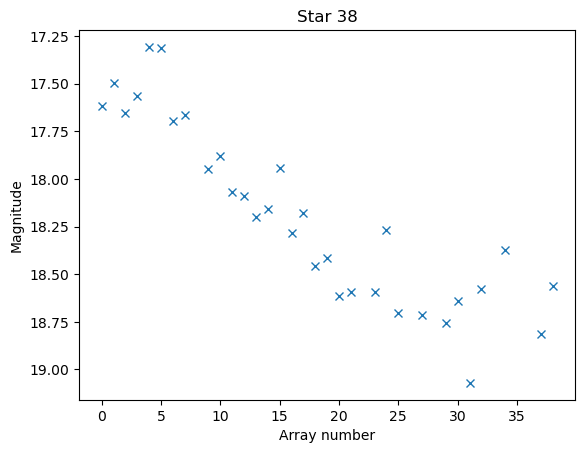

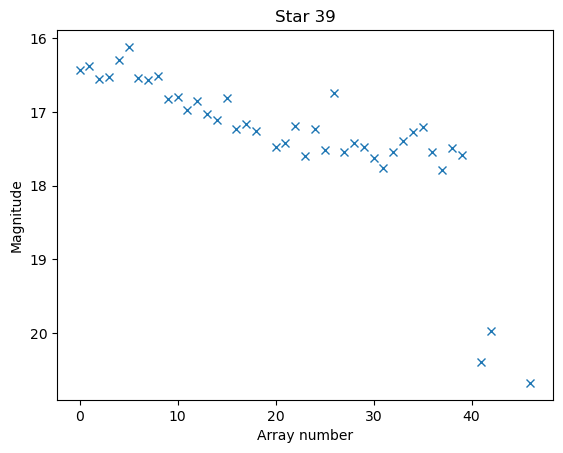

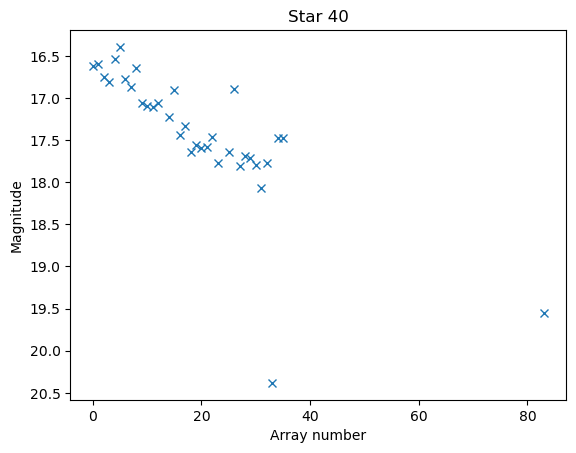

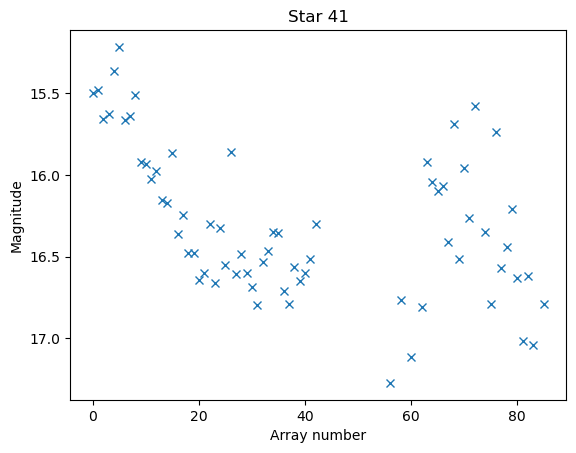

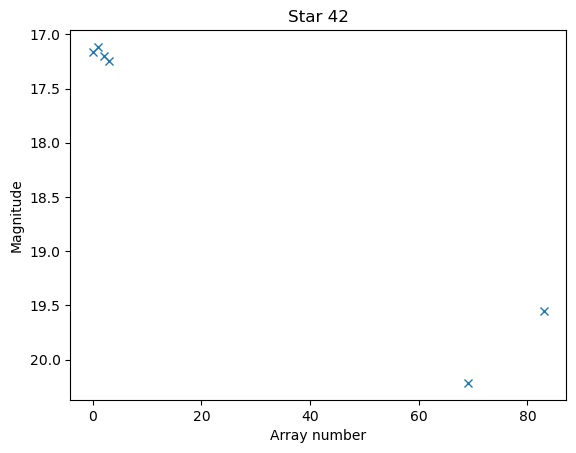

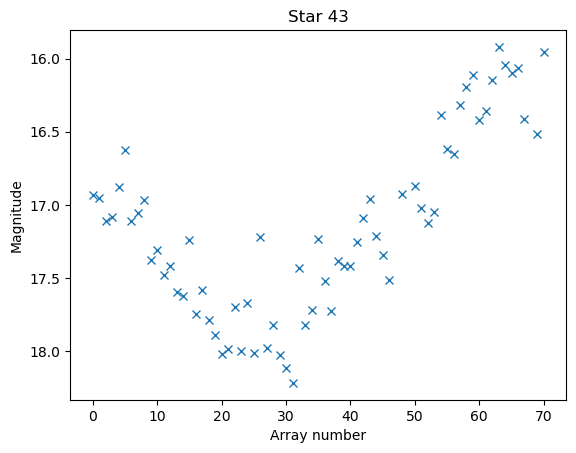

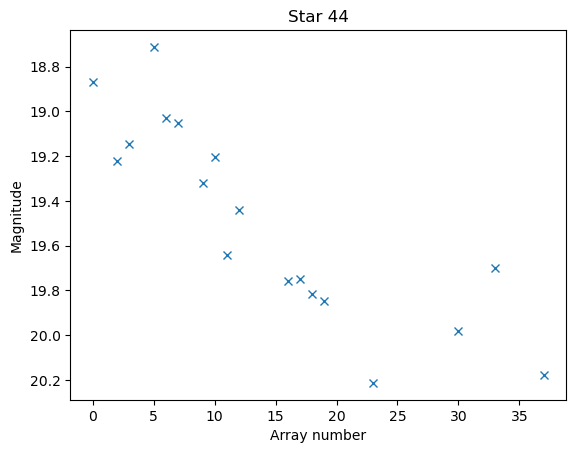

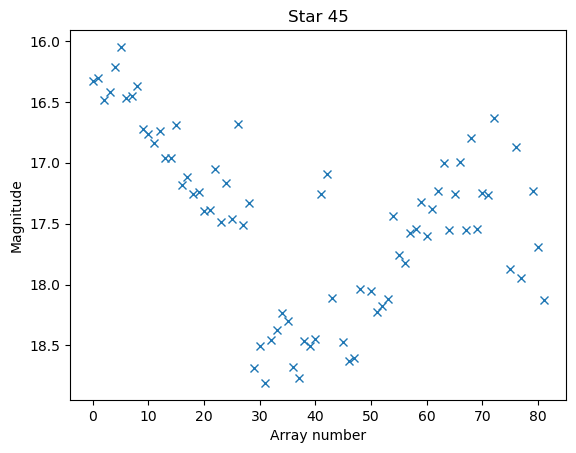

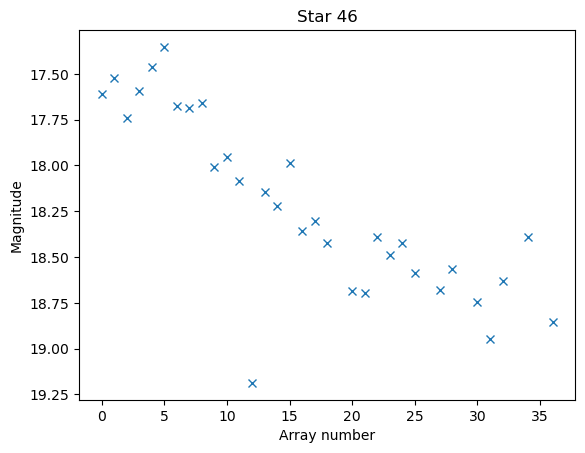

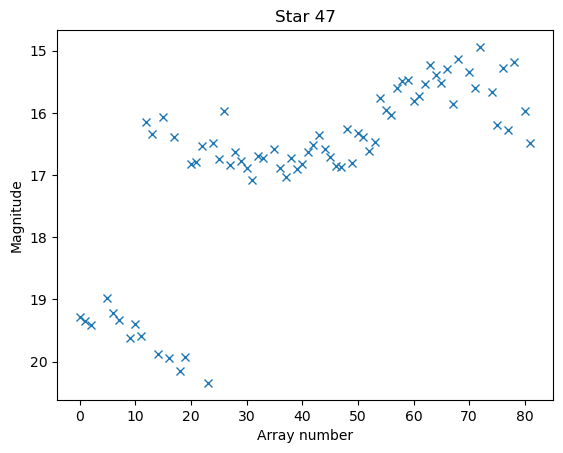

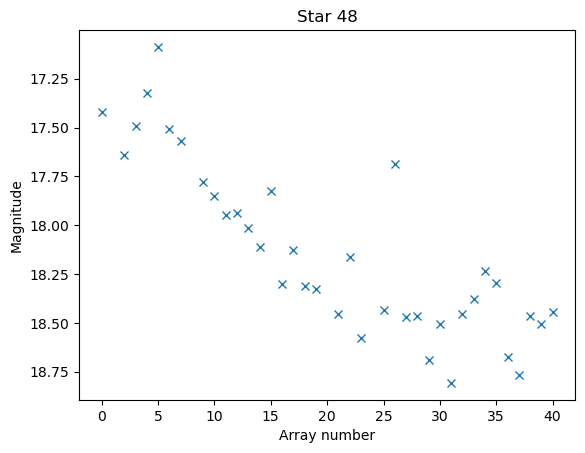

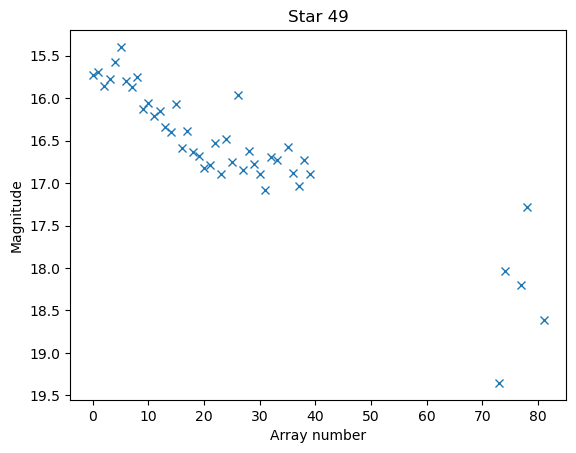

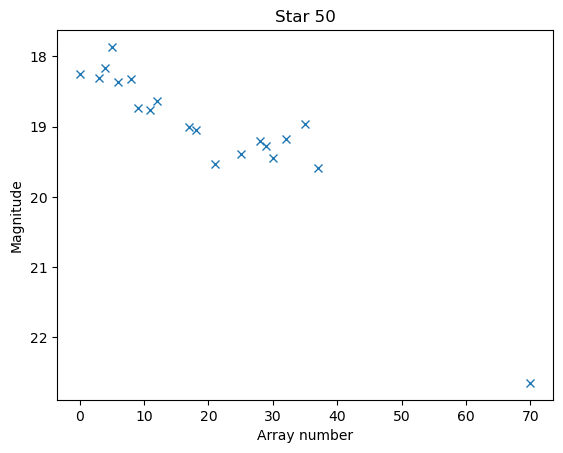

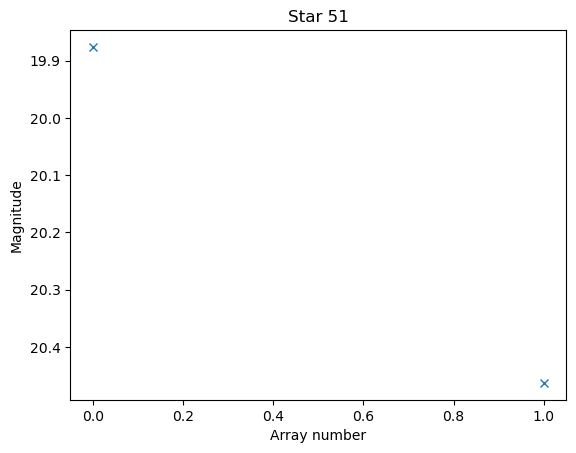

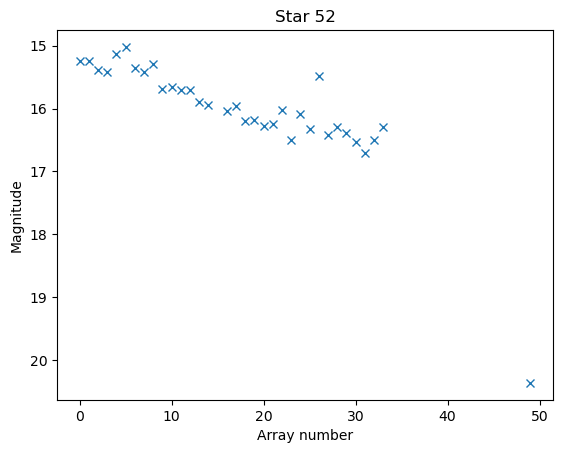

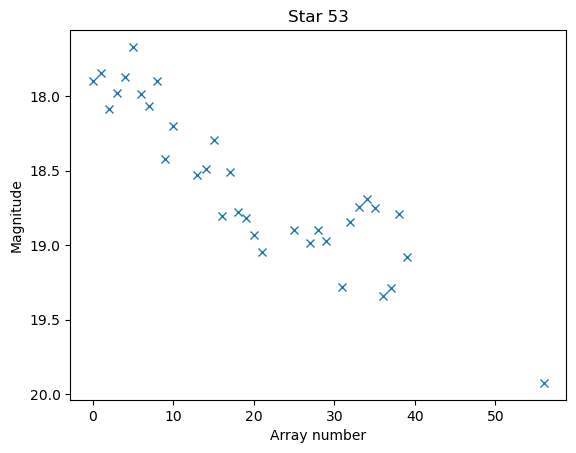

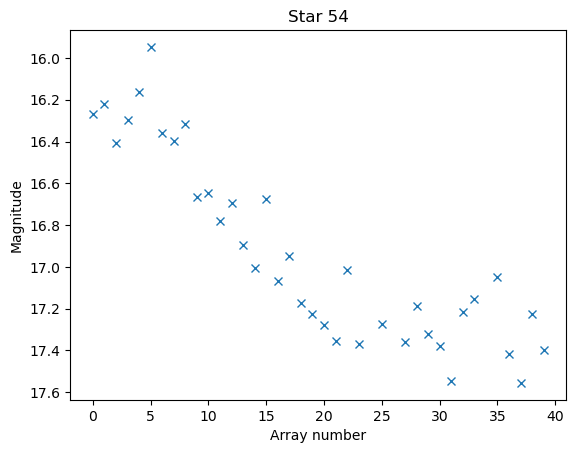

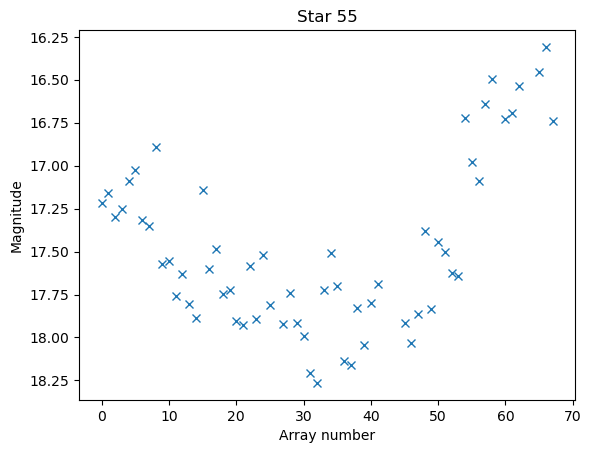

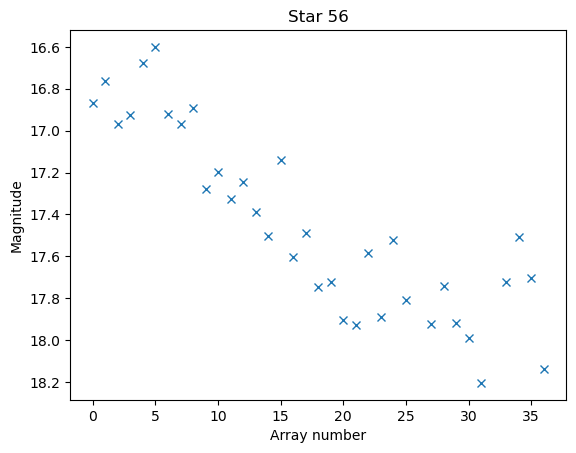

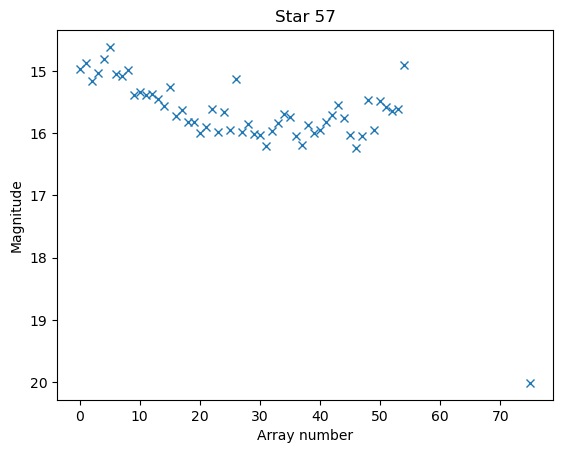

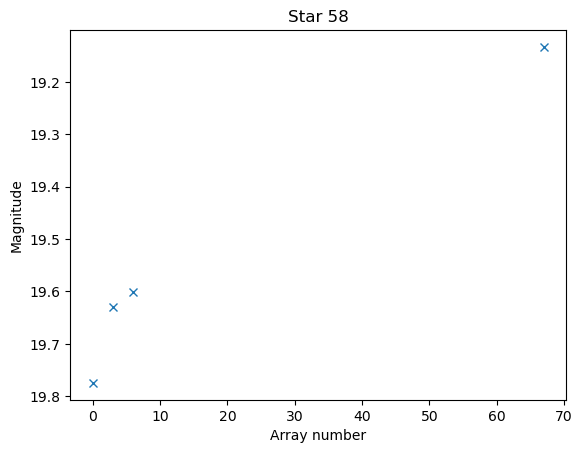

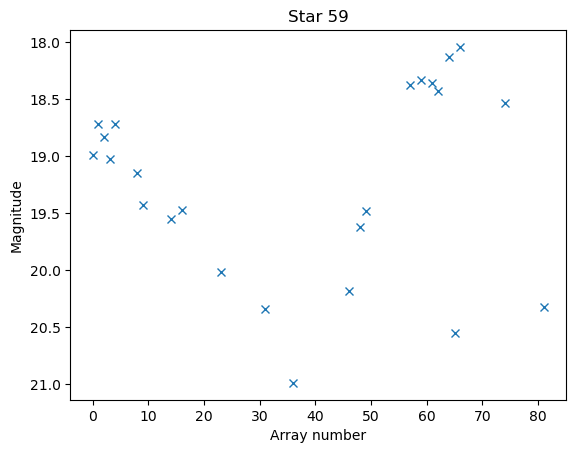

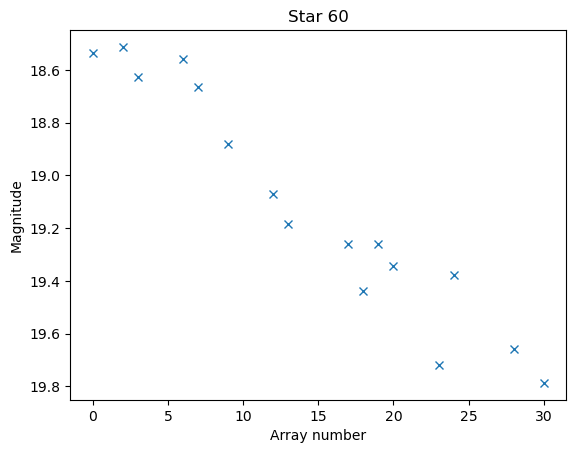

In [26]:
for index, lst in enumerate(magnitude_list_standard_stars):
    plt.plot(lst, 'x')
    plt.title(f'Star {stars_index[index]}')
    plt.xlabel('Array number')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.show()
    plt.close()

In [27]:
bad_stars_index = [0, 3, 4, 8, 9, 10, 13, 14, 16, 17, 18, 20, 21, 24, 27, 28, 29,30, 34, 36, 38, 39, 40, 41]

corrected_stars_index = [i for i in range(len(sources_first_array_no_duplicates)) if i not in bad_stars_index and i not in saturated_stars_and_RV_UMa]

flux_list_standard_stars = [all_fluxes_transposed[i] for i in corrected_stars_index]
magnitude_list_standard_stars = [all_magnitudes_transposed[i] for i in corrected_stars_index]

In [28]:
# Now we transpose the all_magnitudes list so that each list contains all the magnitudes of each star
all_flux_offsets_standard_stars = list()
all_magnitude_offsets_standard_stars = list()
for index, flux_list in enumerate(all_fluxes_transposed):
    if index in corrected_stars_index:
        offset = [flux_list[0]- i for i in flux_list]
        all_flux_offsets_standard_stars.append(offset)

for index, flux_list in enumerate(all_magnitudes_transposed):
    if index in corrected_stars_index:
        offset = [flux_list[0]- i for i in flux_list]
        all_magnitude_offsets_standard_stars.append(offset)

In [29]:
mean_magnitude_offsets = np.nanmean(all_magnitude_offsets_standard_stars, axis = 0)
mean_flux_offsets = np.nanmean(all_flux_offsets_standard_stars, axis = 0)

std_magnitude_offsets = np.nanstd(all_magnitude_offsets_standard_stars, axis = 0)
std_flux_offsets = np.nanstd(all_flux_offsets_standard_stars, axis = 0)

In [30]:
import numpy as np
corrected_RV_UMa_flux = np.array(RV_UMa_fluxes[0]) + mean_flux_offsets
corrected_RV_UMa_magnitude = np.array(RV_UMa_magnitudes[0]) + mean_magnitude_offsets

# Plots

In [31]:
corrected_magnitudes = list()
for star in magnitude_list_standard_stars:
    corrected_magnitudes.append(np.array(star) + mean_magnitude_offsets)

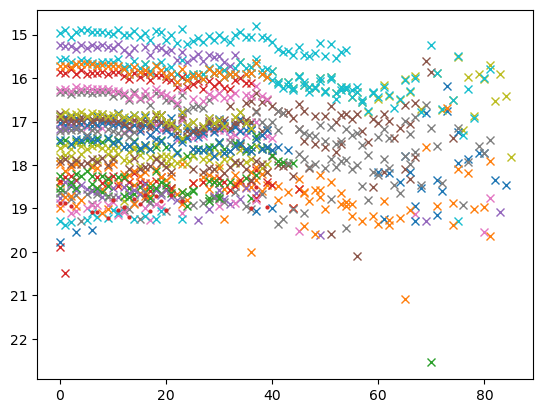

In [32]:
for index, star in enumerate(corrected_magnitudes):
    plt.plot(star, 'x', label = f'Star {corrected_stars_index[index]}')
plt.plot(corrected_RV_UMa_magnitude, 'o', markersize = 2)
# plt.legend()
plt.gca().invert_yaxis();

In [33]:
print('Corrected magnitudes')
print(np.mean(np.nanstd(corrected_magnitudes, axis = 1)))
print(max(np.nanstd(corrected_magnitudes, axis = 1)))
print('\n\n')
print('Corrected RV UMa')
print(np.nanmean(RV_UMa_magnitudes[0]))
print(np.nanstd(RV_UMa_magnitudes[0]))

Corrected magnitudes
0.4164386128711229
1.2343042960026058



Corrected RV UMa
19.47791982467248
0.33603842284449736


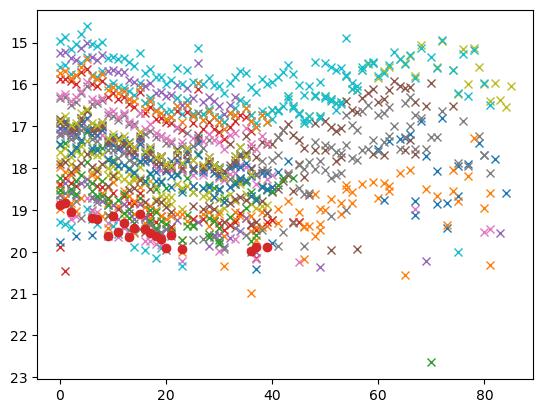

In [34]:
for star in magnitude_list_standard_stars:
    plt.plot(star, 'x')

plt.plot(RV_UMa_magnitudes[0], 'o')
plt.gca().invert_yaxis();

In [35]:
print('Not corrected magnitudes')
print(np.mean(np.nanstd(magnitude_list_standard_stars, axis = 1)))
print(max(np.nanstd(magnitude_list_standard_stars, axis = 1)))
print('Not corrected RV UMa')
print(np.mean(corrected_RV_UMa_magnitude))
print(np.std(corrected_RV_UMa_magnitude))

Not corrected magnitudes
0.606936701300343
1.4295153706720602
Not corrected RV UMa
nan
nan


# Plotting with time on the x-axis

In [36]:
import datetime
from astropy.time import Time

times = [datetime.datetime.strptime(header["DATE-OBS"], '%Y-%m-%dT%H:%M:%S.%f') for header in headers]
times = [Time(i).jd for i in times]
t = [time - times[0] for time in times]

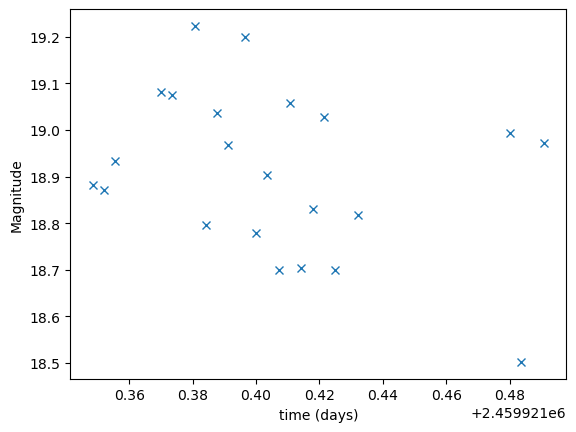

In [37]:
plt.plot(times, corrected_RV_UMa_magnitude, 'x')
plt.xlabel('time (days)')
plt.ylabel('Magnitude');

In [38]:
period = 0.46806 # period in days
phase = np.array(t)/period - np.floor(np.array(t)/period)

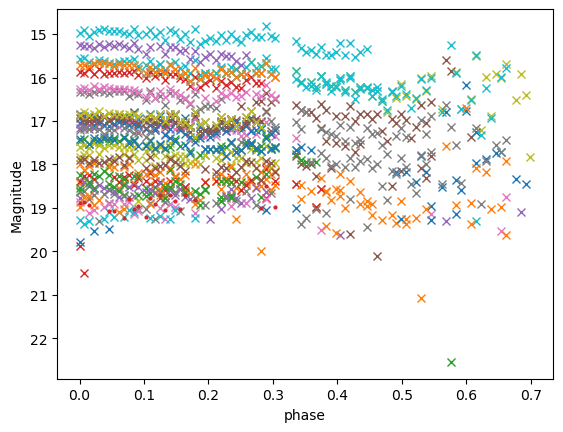

In [39]:
for index, star in enumerate(corrected_magnitudes):
    plt.plot(phase, star, 'x', label = f'Star {corrected_stars_index[index]}')
plt.plot(phase, corrected_RV_UMa_magnitude, 'o', markersize = 2)
# plt.legend()
plt.gca().invert_yaxis();
plt.xlabel('phase')
plt.ylabel('Magnitude');

In [40]:
# Move everything to txt file

with open(f'RZ_CepData{filter.upper()}.txt', 'w') as f:
    f.write(str(filter))
    f.write('\n\n\n***************************************************************\n\n\n')
    f.write(str(phase))
    f.write('\n\n\n***************************************************************\n\n\n')
    f.write(str(corrected_RV_UMa_magnitude))

In [41]:
with open(f'RZ_CepData{filter.upper()}.txt', 'a') as f:
    f.write('\n\n\n***************************************************************\n\n\n')
    f.write(str(np.array(times)))